In [634]:
import os
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat, unumpy
from fbg_utils.loading import data_validation, read_files
from fbg_utils.format import calc_uncer
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [635]:
directory = 'data'

n_peaks = 8
experiments = range(1,5+1)
measurements = range(0,10+1) # number of weights + zero measurement

# Run a quick data validation first
for exp in experiments:
    for meas in measurements: 
        file_name = '{}-{}.txt'.format(exp, meas)
        file_path = os.path.join(directory, file_name)
        measurement = data_validation(file_path, n_peaks=n_peaks)

Validating data in file: data/1-0.txt
Validating data in file: data/1-1.txt
Validating data in file: data/1-2.txt
Validating data in file: data/1-3.txt
Validating data in file: data/1-4.txt
Validating data in file: data/1-5.txt
Validating data in file: data/1-6.txt
Validating data in file: data/1-7.txt
Validating data in file: data/1-8.txt
Validating data in file: data/1-9.txt
Validating data in file: data/1-10.txt
Validating data in file: data/2-0.txt
Validating data in file: data/2-1.txt
Validating data in file: data/2-2.txt
Validating data in file: data/2-3.txt
Validating data in file: data/2-4.txt
Validating data in file: data/2-5.txt
Validating data in file: data/2-6.txt
Validating data in file: data/2-7.txt
Validating data in file: data/2-8.txt
Validating data in file: data/2-9.txt
Validating data in file: data/2-10.txt
Validating data in file: data/3-0.txt
Validating data in file: data/3-1.txt
Validating data in file: data/3-2.txt
Validating data in file: data/3-3.txt
Validating

In [636]:
# Now we start reading in data, we make an n_exp x weight_idx x FBG/n_peaks
n_exp = 5
n_meas = 11
n_peaks = 8
shape = (n_exp, n_meas, n_peaks)
zeros = np.zeros(shape)
complete_data = unumpy.uarray(zeros, zeros)
scale = 1e-9
for exp in experiments:
    for meas in measurements: 
        file_name = '{}-{}.txt'.format(exp, meas)
        file_path = os.path.join(directory, file_name)
        measurement = data_validation(file_path, n_peaks=n_peaks)*scale
        uncert_meas = calc_uncer(measurement)
        complete_data[exp-1, meas] = uncert_meas

Validating data in file: data/1-0.txt
Validating data in file: data/1-1.txt
Validating data in file: data/1-2.txt
Validating data in file: data/1-3.txt
Validating data in file: data/1-4.txt
Validating data in file: data/1-5.txt
Validating data in file: data/1-6.txt
Validating data in file: data/1-7.txt
Validating data in file: data/1-8.txt
Validating data in file: data/1-9.txt
Validating data in file: data/1-10.txt
Validating data in file: data/2-0.txt
Validating data in file: data/2-1.txt
Validating data in file: data/2-2.txt
Validating data in file: data/2-3.txt
Validating data in file: data/2-4.txt
Validating data in file: data/2-5.txt
Validating data in file: data/2-6.txt
Validating data in file: data/2-7.txt
Validating data in file: data/2-8.txt
Validating data in file: data/2-9.txt
Validating data in file: data/2-10.txt
Validating data in file: data/3-0.txt
Validating data in file: data/3-1.txt
Validating data in file: data/3-2.txt
Validating data in file: data/3-3.txt
Validating

In [637]:
# this array is index the following way:
# complete_data[0, 0, 0] means the first experiment, with no weights selected and the first of the FBG peaks
print(complete_data)

[[[1.5159424267924532e-06+/-6.487450064994311e-13
   1.522914907169811e-06+/-6.163736914976781e-13
   1.529860392075472e-06+/-5.457648824933929e-13
   1.5368499322641512e-06+/-6.40506350732226e-13
   1.5438507141509437e-06+/-5.336636049531115e-13
   1.5508657164150944e-06+/-4.929864321480679e-13
   1.557902293773585e-06+/-5.728602437303746e-13
   1.5649901484905662e-06+/-5.895469235861422e-13]
  [1.51637069462963e-06+/-7.103579063865584e-13
   1.5233451792592594e-06+/-8.347999567885628e-13
   1.5302926324074075e-06+/-7.531214713173889e-13
   1.5372850307407413e-06+/-7.352084968871837e-13
   1.5442876916666671e-06+/-7.135880470823435e-13
   1.5513028394444442e-06+/-8.747539860767396e-13
   1.5583415666666666e-06+/-8.094462933938783e-13
   1.5654329522222222e-06+/-7.963077136716691e-13]
  [1.5168021979545456e-06+/-1.8744347333214434e-12
   1.5237822093181816e-06+/-1.9373982190283804e-12
   1.5307316852272728e-06+/-1.9948295795708297e-12
   1.5377244915909092e-06+/-1.9552537965246406e-12


In [638]:
def strain(lamb_r, lamb_b, n, p_e):
    strain = (lamb_b - lamb_r)/(lamb_r*(1-((n**2)/2)*p_e))
    return strain

def area(diameter):
    return np.pi*(0.5*diameter)**2

def force(strain, young, area):
    force = strain*young*area
    return force

def composit_strain(force, area_core, area_fiber, E_core, E_fiber):
    return force/(E_core*area_core+E_fiber*area_fiber)

def fit_func(x, a):
    return a*x 

In [639]:
# small test with only the first experiments and the first FBG sensor
meas1 = complete_data[0, :, 0]

#some constants
n = ufloat(1.46, 0.005) # fuzed silica glass
p_e = ufloat(0.20, 0.005)
in_diameter = ufloat(125e-6, 1e-6)
out_diameter = ufloat(195e-6, 1e-6)
inner_area = area(in_diameter)
outer_area = area(out_diameter)
lamb_r = meas1[0]
lamb_b = meas1
young_core = 70e9 #https://fbgs.com/faq/what-is-the-youngs-modulus-of-the-dtg-sensor/
young_clad = 2e9 #https://fbgs.com/faq/what-is-the-youngs-modulus-of-the-dtg-sensor/




[0.0+/-1.0970515070793508e-07 0.0003850650789848521+/-5.75765092765143e-06
 0.0007701301579697042+/-1.1512688683286899e-05
 0.0011551952369545564+/-1.72680747265259e-05
 0.0015414670725971958+/-2.3041584211132424e-05
 0.0019270806773355874+/-2.8805290876155674e-05
 0.0023115972305668996+/-3.4552617980823195e-05
 0.0026953458477432567+/-4.028847689507194e-05
 0.0030824953245915596+/-4.607517312748069e-05
 0.0034673409932749954+/-5.182743949979098e-05
 0.0038521866619584317+/-5.757970874003004e-05]


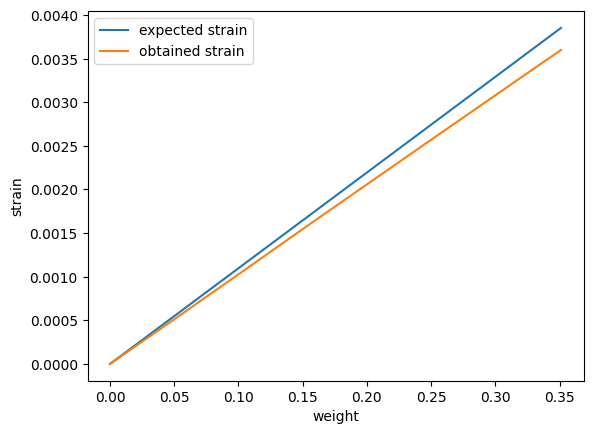

In [640]:
# wavelenght method
calculated_strain = strain(lamb_b, lamb_r, n, p_e)*-1

#weights method
weights = np.array([0, 35.10, 35.10, 35.10 ,35.21 ,35.15 ,35.05 ,34.98 ,35.29 ,35.08 ,35.08])/1e3
uncertainty = np.ones(11)*0.00001
weights = unumpy.uarray(weights, uncertainty)
cum_weight = np.cumsum(weights)
exp_force = cum_weight*9.81
expected_strain = composit_strain(exp_force, inner_area, outer_area-inner_area, young_core, young_clad)

print(expected_strain)

plt.figure()
plt.plot(unumpy.nominal_values(cum_weight), unumpy.nominal_values(expected_strain), label="expected strain")
plt.plot(unumpy.nominal_values(cum_weight), unumpy.nominal_values(calculated_strain), label="obtained strain")
plt.legend()
plt.xlabel("weight")
plt.ylabel("strain")
plt.show()

Coefficients: [0.78859405]
Errors (±): [2.14680997e-05]
R-squared: 0.8430081196946737


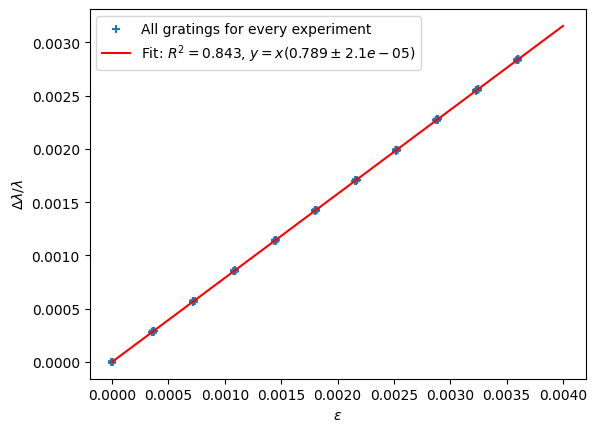

In [641]:
# Format data 
# wavelenght against lambda
meas = complete_data[:, :, :]
wl_series = []
strain_series = []
n_exp = 5
n_meas = 11
n_peaks = 8

for exp in range(n_exp):
    for peak in range(n_peaks):
        series = meas[exp, :, peak]
        lamb_r = series[0]
        lamb_b = series[:]
        rel_wl = (lamb_b-lamb_r)/lamb_r
        calc_strain = strain(lamb_b, lamb_r, n, p_e)*-1
        wl_series.append(rel_wl)
        strain_series.append(calc_strain)

wl_series = np.array(wl_series).flatten()
strain_series = np.array(strain_series).flatten()
nom_wl_series = unumpy.nominal_values(wl_series)
nom_strain_series = unumpy.nominal_values(strain_series)

# make linear fit
coef, cov = curve_fit(fit_func, nom_strain_series, nom_wl_series)  # Extract covariance matrix
print("Coefficients:", coef)

# Calculate the standard deviation (square root of diagonal of covariance matrix) for the error
errors = np.sqrt(np.diag(cov))
print("Errors (±):", errors)

# Generate line for plotting
line_x = np.linspace(0, 0.004, 2)
line_y = fit_func(line_x, coef)

# Calculate R-squared
r_squared = r2_score(nom_strain_series, fit_func(nom_strain_series, coef))
print("R-squared:", r_squared)


plt.figure()
plt.scatter(nom_strain_series, nom_wl_series, marker='+', label="All gratings for every experiment")
plt.xlabel("$\epsilon$")
plt.ylabel("$\Delta\lambda / \lambda$")
min_x = np.min(nom_strain_series)
max_x = np.max(nom_strain_series)
plt.plot(line_x, line_y, color='r', label="Fit: $R^2={}$, $y=x({}\pm{})$".format(round(r_squared, 3), round(coef[0], 3), round(errors[0], 6)))
plt.legend()
